### Read libraries

In [1]:
import pyreadstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.feature_selection as fs
import statsmodels.api as sm
import scipy.stats as stats

from matplotlib.patches import Patch
from pandas.api.types import CategoricalDtype
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.miscmodels.ordinal_model import OrderedModel


%matplotlib inline
warnings.filterwarnings('ignore')

### Read the data

In [2]:
df_wave1, meta = pyreadstat.read_sav("Wave1_20170906.sav")
df_wave1.head()

,country,idnumber,level3,yrsurvey,se002,se003,se003a,se004,se004a,se005,...,ir010e,w_jp,w_hk,w_kr,w_cn,w_mo,w_ph,w_tw,w_th,w_all
0,4.0,1.0,1.0,2002.0,1.0,5.0,38.0,NaN,1.0,5.0,...,NaN,NaN,NaN,NaN,0.621390,NaN,NaN,NaN,NaN,0.62
1,4.0,2.0,1.0,2002.0,2.0,10.0,60.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.446785,NaN,NaN,NaN,NaN,0.45
2,4.0,3.0,1.0,2002.0,2.0,10.0,69.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,0.583658,NaN,NaN,NaN,NaN,0.58
3,4.0,4.0,1.0,2002.0,2.0,5.0,39.0,NaN,1.0,8.0,...,NaN,NaN,NaN,NaN,0.490000,NaN,NaN,NaN,NaN,0.49
4,4.0,5.0,1.0,2002.0,1.0,7.0,48.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.396647,NaN,NaN,NaN,NaN,0.40


## Data Wrangling

In [3]:
# read the data dictionary
data_dictionary = pd.read_csv("D2-ABS1+2.csv", header=1)

#### Select only the columns of interest

In [4]:
def select_important_columns(data_dictionary, dataset):
  col_names = data_dictionary["ABS1_Coding_name"][0:-6]
  return df_wave1[col_names]

In [5]:
merged_data = pd.merge(df_wave1[['country']], select_important_columns(data_dictionary, df_wave1))

In [6]:
merged_data.head()

,country,se002,se004,se005,se009,se003a,q007,q008,q009,q010,...,q098,q128,q005,q027,q028,q105,q106,q121,q123,q127
0,4.0,1.0,NaN,5.0,5.0,38.0,3.0,3.0,3.0,3.0,...,2.0,3.0,4.0,2.0,NaN,5.0,3.0,NaN,3.0,2.0
1,4.0,2.0,NaN,4.0,5.0,60.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0
2,4.0,2.0,NaN,1.0,5.0,69.0,4.0,4.0,4.0,4.0,...,NaN,NaN,3.0,NaN,NaN,2.0,3.0,NaN,NaN,3.0
3,4.0,2.0,NaN,8.0,5.0,39.0,4.0,4.0,4.0,4.0,...,3.0,3.0,2.0,2.0,NaN,5.0,3.0,NaN,3.0,NaN
4,4.0,1.0,NaN,4.0,5.0,48.0,4.0,4.0,4.0,4.0,...,NaN,2.0,3.0,NaN,NaN,4.0,3.0,NaN,3.0,2.0


In [7]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22191011 entries, 0 to 22191010
Data columns (total 21 columns):
 #   Column   Dtype  
---  ------   -----  
 0   country  float64
 1   se002    float64
 2   se004    float64
 3   se005    float64
 4   se009    float64
 5   se003a   float64
 6   q007     float64
 7   q008     float64
 8   q009     float64
 9   q010     float64
 10  q006     float64
 11  q098     float64
 12  q128     float64
 13  q005     float64
 14  q027     float64
 15  q028     float64
 16  q105     float64
 17  q106     float64
 18  q121     float64
 19  q123     float64
 20  q127     float64
dtypes: float64(21)
memory usage: 3.6 GB


#### Explore variables

In [8]:
merged_data.q098.value_counts()

3.0    11481534
2.0     5235324
4.0     2656754
1.0      751463
Name: q098, dtype: int64

In [9]:
merged_data.q005.value_counts()

4.0    7643476
3.0    6014953
2.0    5201697
5.0    1800464
1.0    1397137
Name: q005, dtype: int64

#### Change datatype for non numerical values to categorical ordinal or categorical norminal

In [10]:
cat1 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=True)
cat2 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0], ordered=True)
for column in merged_data.columns:
  if column != "se003a": #not age
    if column == "q006" or column == "q005" or column == "q105" or column == "q106" or column == "se009":
      merged_data[column] = merged_data[column].astype(cat1)
    if column == "q098" or column == "q123" or column == "q121" or column == "q127" or column == "q128" \
        or column == "q008" or column == "q009" or column == "q010":
        merged_data[column] = merged_data[column].astype(cat2)
    merged_data[column] = merged_data[column].astype("category")

In [11]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22191011 entries, 0 to 22191010
Data columns (total 21 columns):
 #   Column   Dtype   
---  ------   -----   
 0   country  category
 1   se002    category
 2   se004    category
 3   se005    category
 4   se009    category
 5   se003a   float64 
 6   q007     category
 7   q008     category
 8   q009     category
 9   q010     category
 10  q006     category
 11  q098     category
 12  q128     category
 13  q005     category
 14  q027     category
 15  q028     category
 16  q105     category
 17  q106     category
 18  q121     category
 19  q123     category
 20  q127     category
dtypes: category(20), float64(1)
memory usage: 761.9 MB


### Missing data

In [12]:
merged_data.isna().sum()

country           0
se002         12368
se004      10154431
se005         68666
se009       1310033
se003a      1350731
q007        2481561
q008        1300395
q009        1130763
q010        1771056
q006        2710052
q098        2065936
q128        2689416
q005         133284
q027        4760657
q028       14673905
q105        1838917
q106        2347510
q121       10639269
q123        2048706
q127        2278003
dtype: int64

##### Drop columns that have more 60% missing data

In [13]:
merged_data_dropped = merged_data.drop(['se004', 'q028', 'q121'], axis=1)

### Impute missing values with most frequent value in column

In [14]:
imp = SimpleImputer(strategy="most_frequent")
imputed_data = imp.fit_transform(merged_data_dropped)

In [15]:
merged_imputed_data = pd.DataFrame(imputed_data, columns = merged_data_dropped.columns)
merged_imputed_data.isna().sum()

country    0
se002      0
se005      0
se009      0
se003a     0
q007       0
q008       0
q009       0
q010       0
q006       0
q098       0
q128       0
q005       0
q027       0
q105       0
q106       0
q123       0
q127       0
dtype: int64

In [16]:
merged_imputed_data.to_csv("clean_data.csv")

### Select a random subset of data to work with

In [17]:
df_sample = merged_imputed_data.groupby("country").sample(n = 10000, replace = True,
                                                          random_state = 0).reset_index(drop=True)
df_sample.head()

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q098,q128,q005,q027,q105,q106,q123,q127
0,1.0,2.0,7.0,3.0,42.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,2.0,4.0,4.0,4.0,2.0
1,1.0,2.0,8.0,2.0,49.0,3.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,2.0,5.0,4.0,4.0,2.0
2,1.0,1.0,8.0,3.0,40.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,5.0,3.0,4.0,3.0
3,1.0,2.0,7.0,1.0,29.0,3.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,1.0,5.0,5.0,4.0,1.0
4,1.0,1.0,8.0,5.0,23.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,2.0,4.0,4.0,4.0,2.0


## Exploratory Data Analysis

<AxesSubplot:xlabel='se003a', ylabel='Density'>

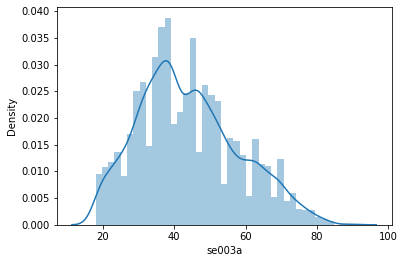

In [18]:
sns.distplot(df_sample.loc[df_sample['country']==4.0]['se003a'])

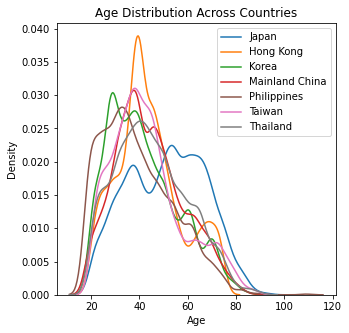

In [19]:
plt.figure(figsize=(5,5))
sns.distplot(df_sample.loc[df_sample['country']==1.0]['se003a'], hist=False, label = "Japan")
sns.distplot(df_sample.loc[df_sample['country']==2.0]['se003a'], hist=False, label = "Hong Kong")
sns.distplot(df_sample.loc[df_sample['country']==3.0]['se003a'], hist=False, label = "Korea")
sns.distplot(df_sample.loc[df_sample['country']==4.0]['se003a'], hist=False, label = "Mainland China")
#Mogolia has no age distribution
sns.distplot(df_sample.loc[df_sample['country']==5.0]['se003a'], hist=False, label = "Mongolia")
sns.distplot(df_sample.loc[df_sample['country']==6.0]['se003a'], hist=False, label = "Philippines")
sns.distplot(df_sample.loc[df_sample['country']==7.0]['se003a'], hist=False, label = "Taiwan")
sns.distplot(df_sample.loc[df_sample['country']==8.0]['se003a'], hist=False, label = "Thailand")
plt.title("Age Distribution Across Countries")
plt.legend()
plt.xlabel("Age")
plt.show()

Text(0.5, 0.98, 'Country vs. Democracy')

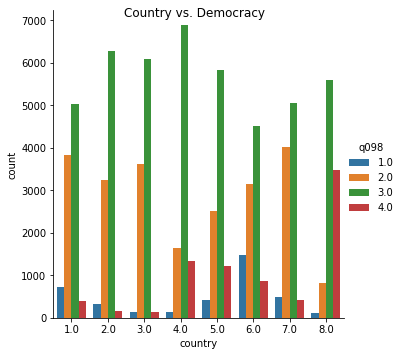

In [20]:
sns.catplot(x="country", hue="q098", data=df_sample, kind="count")
plt.suptitle("Country vs. Democracy")

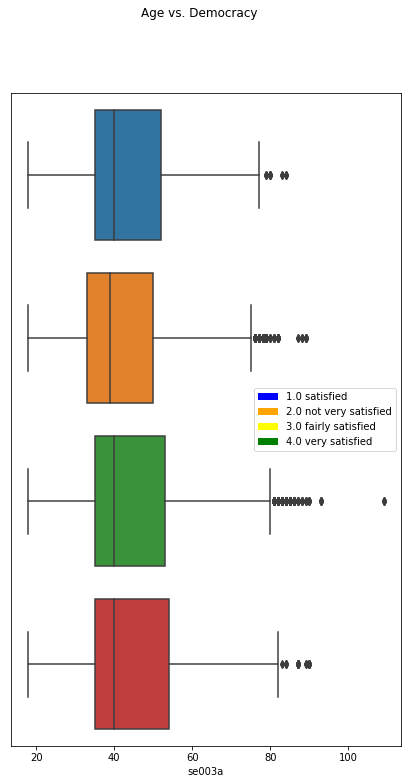

In [21]:
fig, ax = plt.subplots(figsize=(7,12))
sns.boxplot(x="se003a", y="q098", data=df_sample, orient="h", ax=ax)
ax.get_yaxis().set_visible(False)
fig.suptitle("Age vs. Democracy")
color_patches = [
    Patch(facecolor="blue", label="1.0 satisfied"),
    Patch(facecolor="orange", label="2.0 not very satisfied"),
    Patch(facecolor="yellow", label="3.0 fairly satisfied"),
    Patch(facecolor="green", label="4.0 very satisfied")
]
ax.legend(handles=color_patches);

Text(0.5, 0.98, 'Country vs. Democracy by Gender')

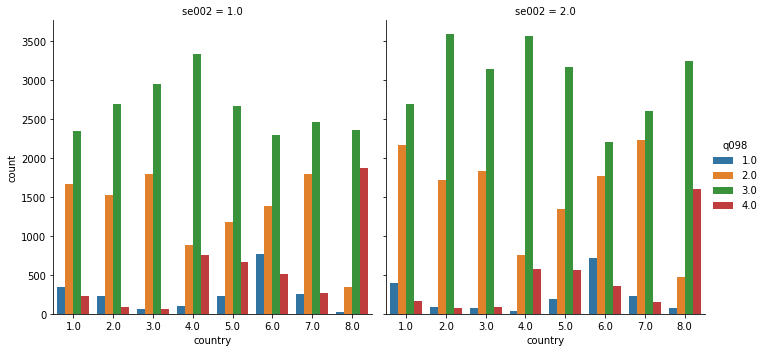

In [22]:
sns.catplot(col="se002", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Gender")

Text(0.5, 0.98, 'Country vs. Democracy by Education')

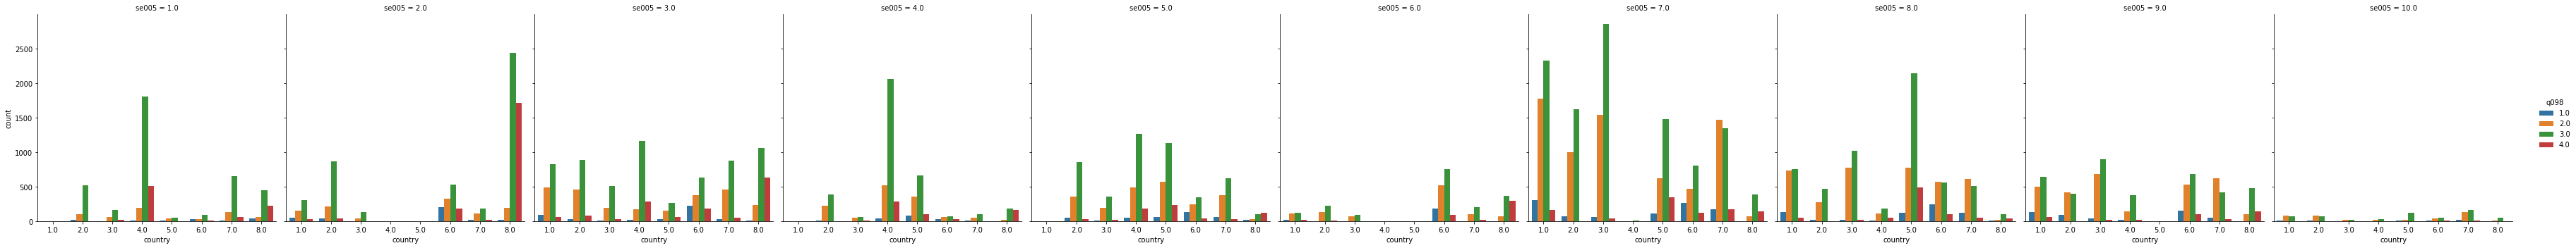

In [23]:
sns.catplot(col="se005", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Education")

Text(0.5, 0.98, 'Country vs. Democracy by Income')

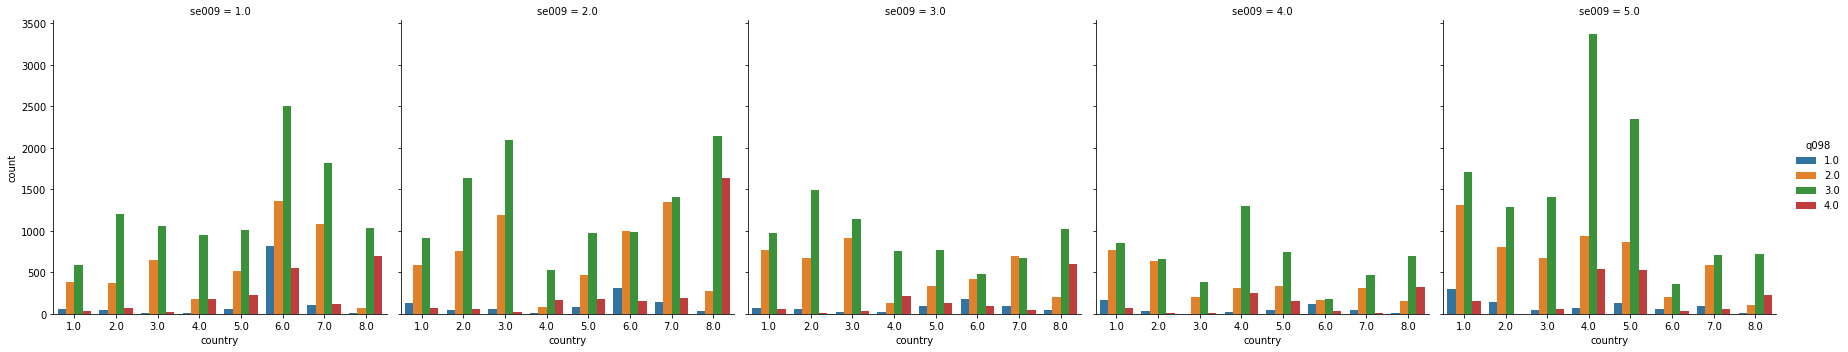

In [24]:
sns.catplot(col="se009", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Income")

Text(0.5, 0.98, 'Country vs. Democracy by Voted last election ')

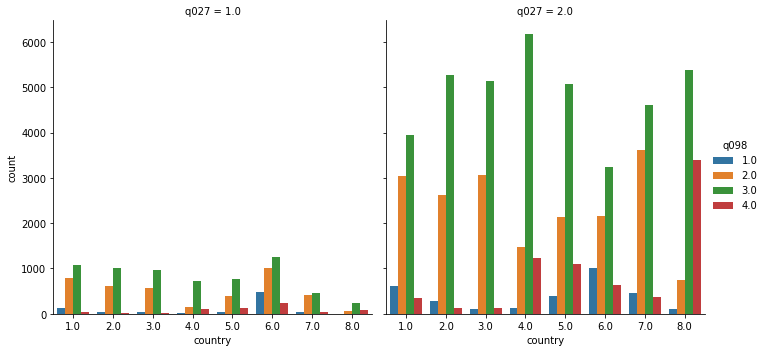

In [25]:
sns.catplot(col="q027", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Voted last election ")

Text(0.5, 0.98, 'Country vs. Democracy by Military')

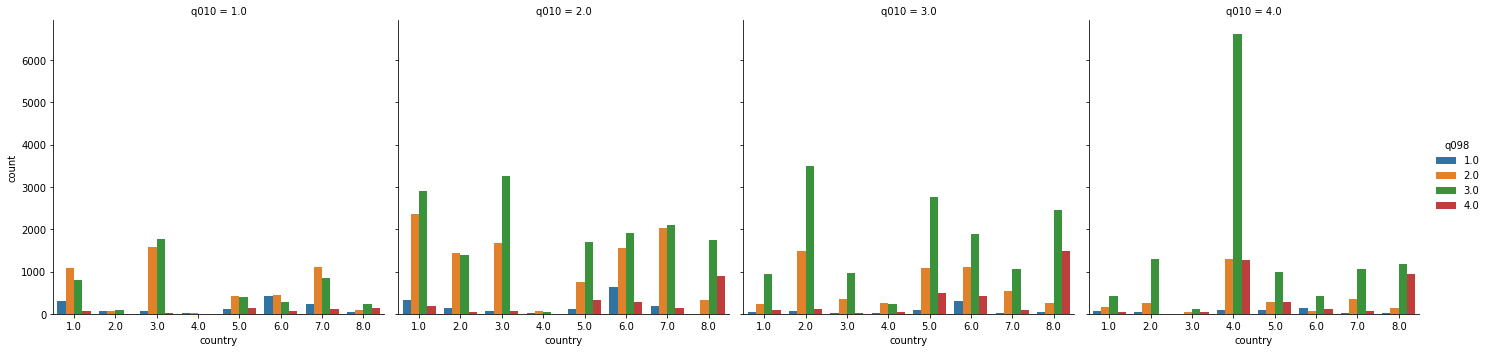

In [26]:
sns.catplot(col="q010", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Military")

Text(0.5, 0.98, 'Country vs. Democracy by Courts')

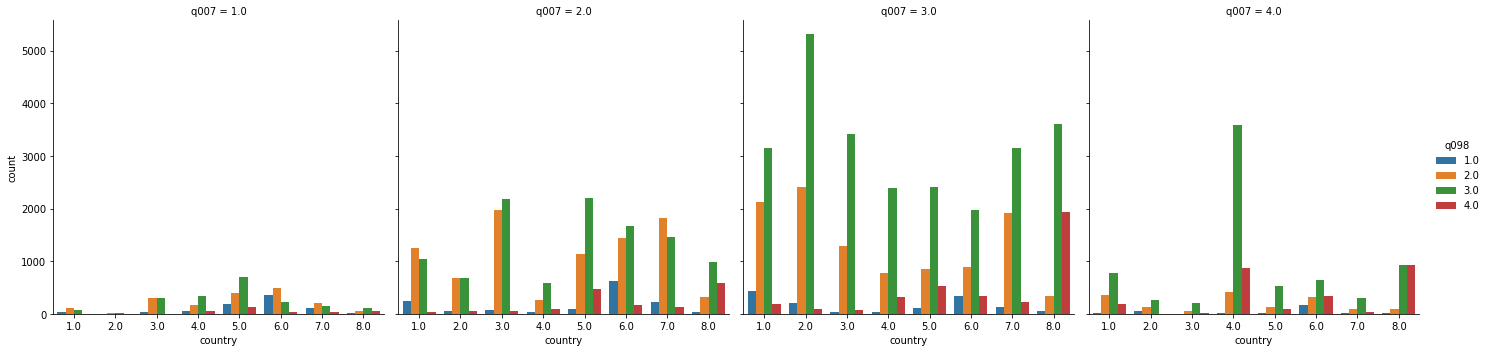

In [27]:
sns.catplot(col="q007", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Courts")

Text(0.5, 0.98, 'Country vs. Democracy by National Government')

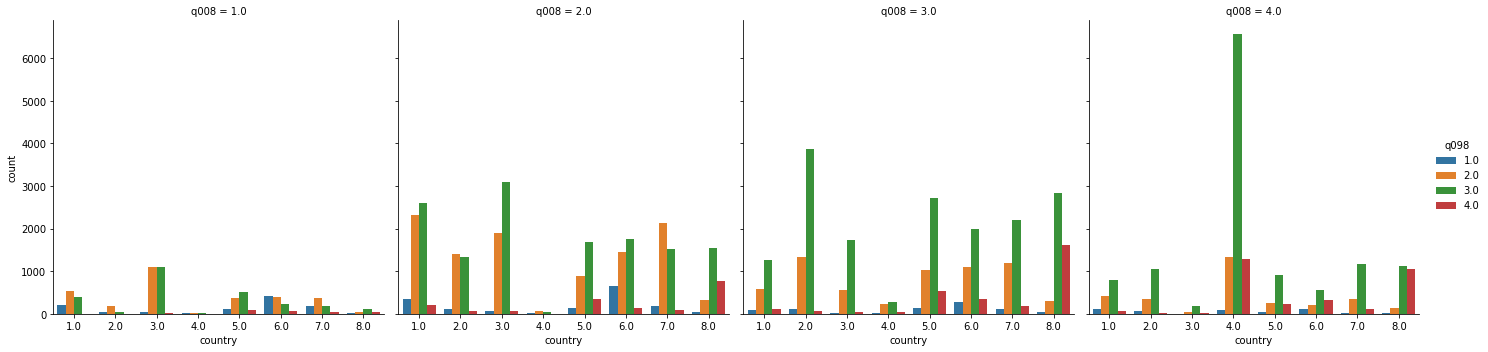

In [28]:
sns.catplot(col="q008", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by National Government")

Text(0.5, 0.98, 'Country vs. Democracy by Civil Service')

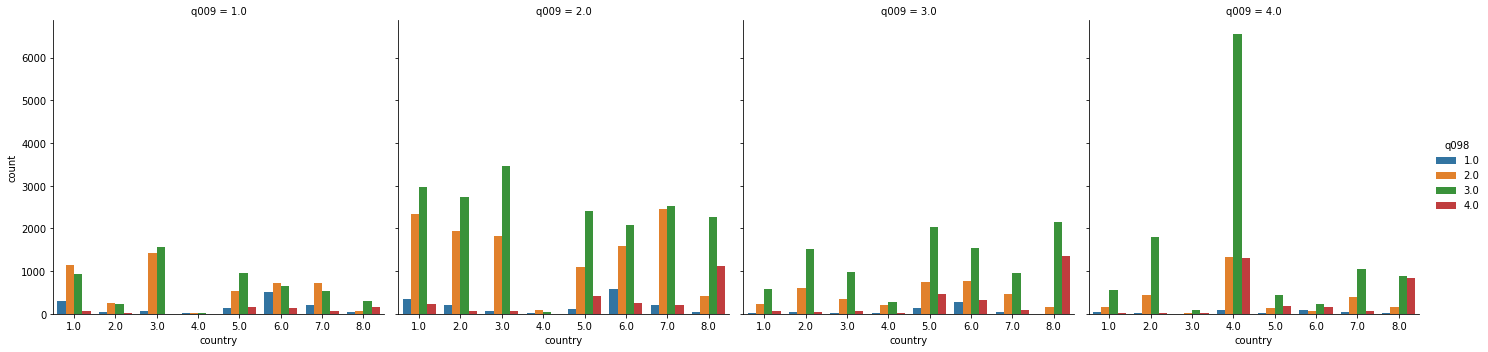

In [29]:
sns.catplot(col="q009", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Civil Service")

Text(0.5, 0.98, 'Country vs. Democracy by Economic situation future')

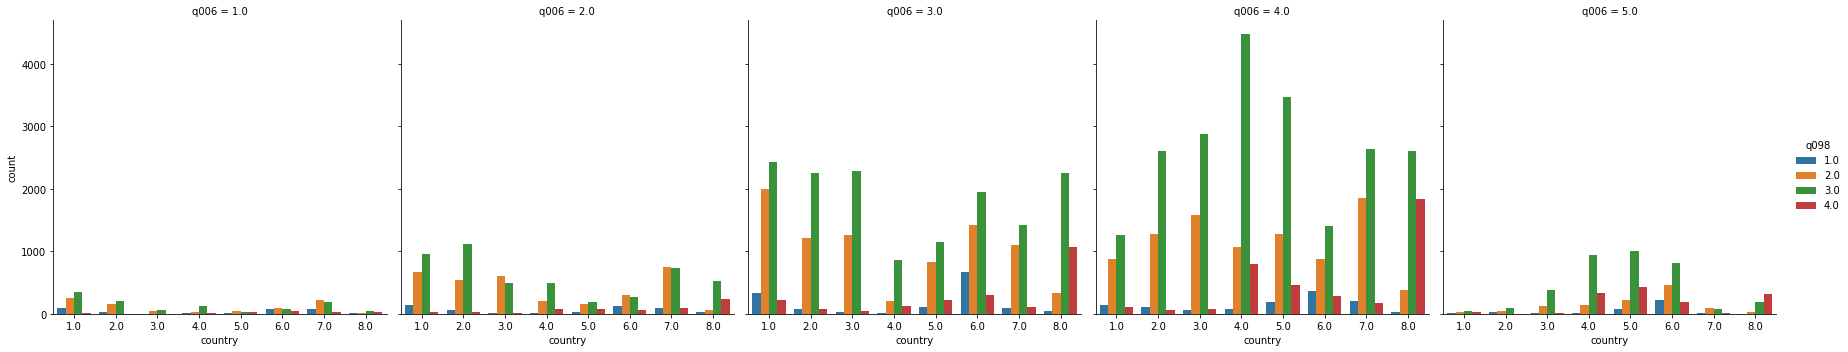

In [30]:
sns.catplot(col="q006", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Economic situation future")

Text(0.5, 0.98, 'Country vs. Democracy by Comparison of Current Economy')

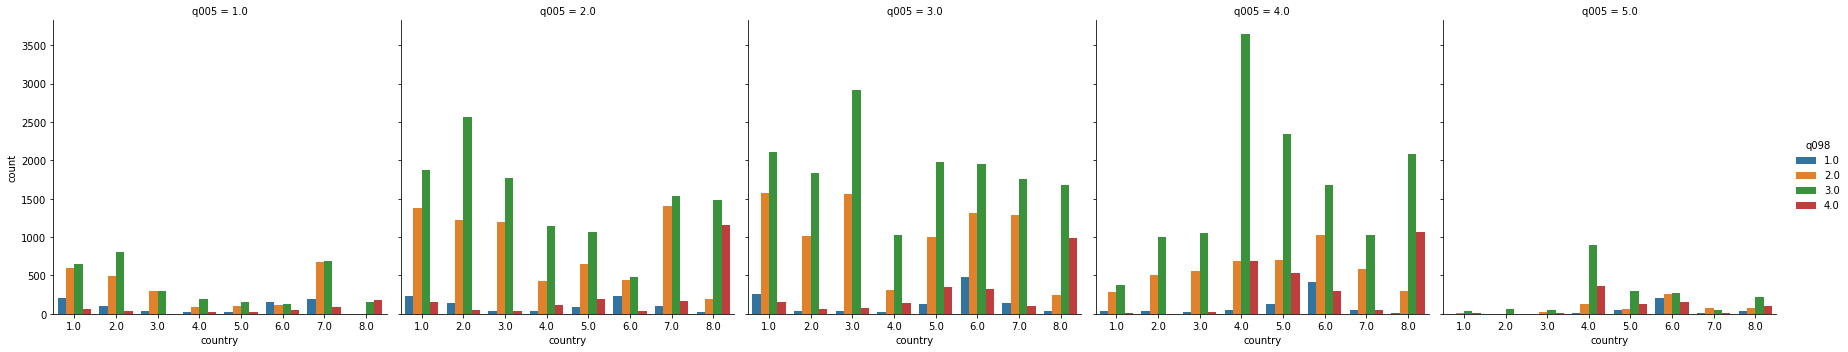

In [31]:
sns.catplot(col="q005", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Comparison of Current Economy")

Text(0.5, 0.98, 'Country vs. Democracy by Trust in Governance')

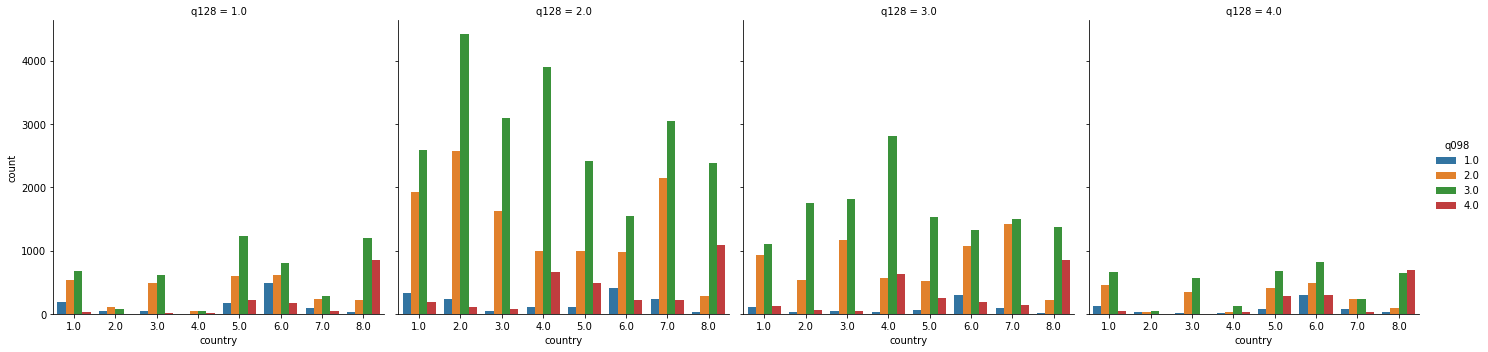

In [32]:
sns.catplot(col="q128", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Trust in Governance")

Text(0.5, 0.98, 'Country vs. Democracy by Freedom of Speech')

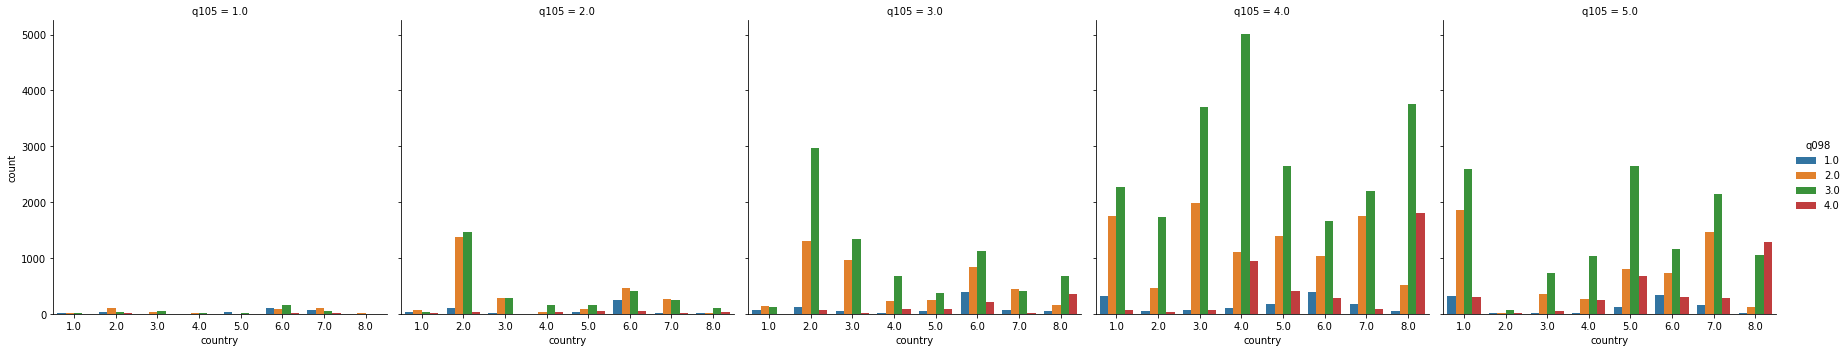

In [33]:
sns.catplot(col="q105", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Freedom of Speech")

Text(0.5, 0.98, 'Country vs. Democracy by Equality')

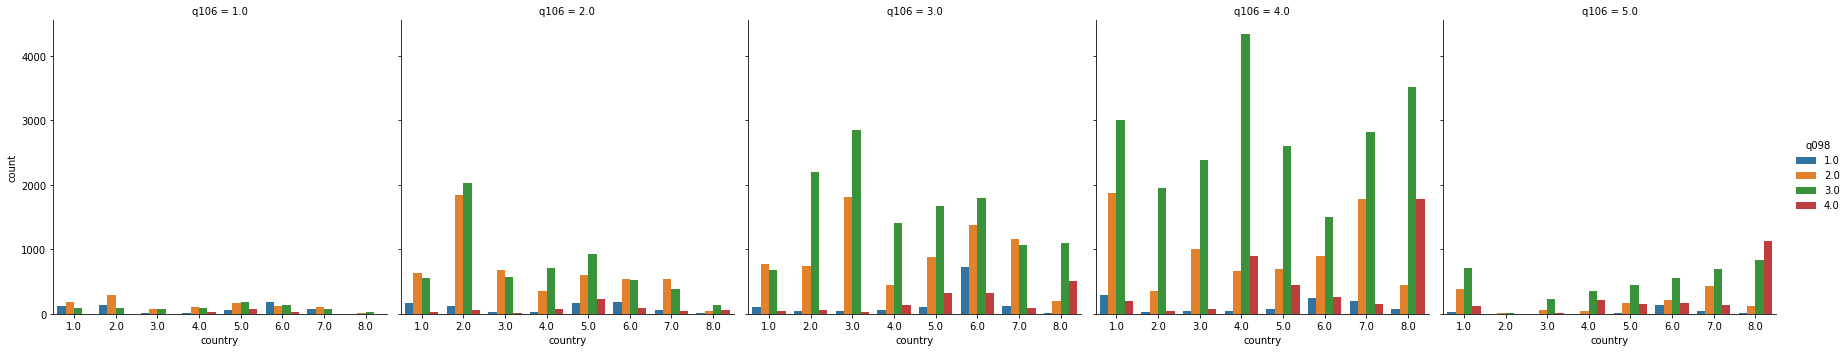

In [34]:
sns.catplot(col="q106", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Equality")

Text(0.5, 0.98, 'Country vs. Democracy by Military Run Govt')

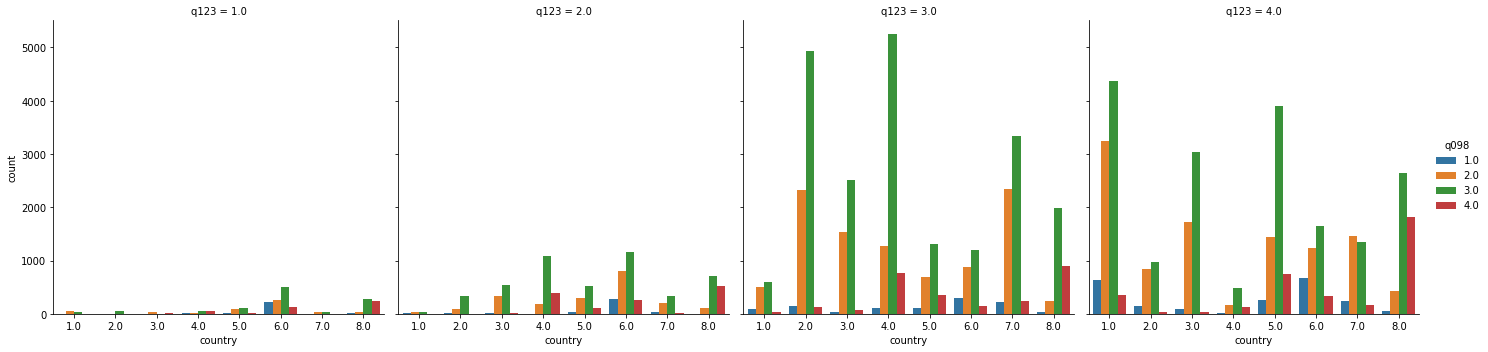

In [35]:
sns.catplot(col="q123", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Military Run Govt")

Text(0.5, 0.98, 'Country vs. Democracy by Politics Knowledge')

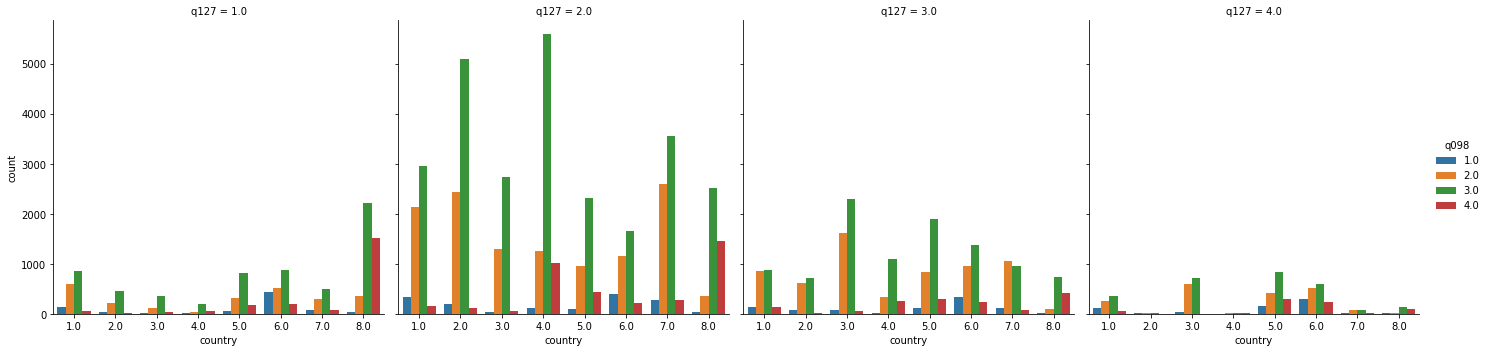

In [36]:
sns.catplot(col="q127", hue="q098", x="country", data=df_sample, kind="count", ax=ax)
fig.suptitle("Country vs. Democracy by Politics Knowledge")

## Model Building

##### Model 1: Probit Ordered Model(Democratics)

In [37]:
train, test = train_test_split(df_sample, test_size=0.30, random_state=0, shuffle=False)

In [38]:
model = OrderedModel(train['q098'], 
                     train[['se002', 'se005', 'se009', 'se003a', 'country', 'q007', 'q008', 
                                      'q009', 'q010', 'q006', 'q128', 'q005', 'q027', 'q105', 'q106', 
                                       'q123', 'q127']], 
                     distr='probit')

In [39]:
res_prob = model.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.918250
         Iterations: 30
         Function evaluations: 35
         Gradient evaluations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   q098   Log-Likelihood:                -51422.
Model:                   OrderedModel   AIC:                         1.029e+05
Method:            Maximum Likelihood   BIC:                         1.031e+05
Date:                Sat, 06 Nov 2021                                         
Time:                        22:07:58                                         
No. Observations:               56000                                         
Df Residuals:                   55980                                         
Df Model:                          20                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
se002         -0.0367      0.010     -3.749      0.000      -0.056      -0.017
se005         -0.0265      0.003    -10.359      0.000      -0.031      -0.021
se009         -0.0172      0.003     -5.007      0.000      -0.024      -0.010
se003a         0.0020      0.000      4.788      0.000       0.001       0.003
country        0.0156      0.004      4.300      0.000       0.009       0.023
q007           0.1408      0.007     19.670      0.000       0.127       0.155
q008           0.0827      0.008     10.968      0.000       0.068       0.097
q009           0.0567      0.007      7.718      0.000       0.042       0.071
q010           0.1135      0.008     14.663      0.000       0.098       0.129
q006           0.0966      0.006     16.368      0.000       0.085       0.108
q128           0.0729      0.006     11.575      0.000       0.061       0.085
q005           0.0735      0.006     13.313      0.000       0.063       0.084
q027           0.0413      0.013      3.151      0.002       0.016       0.067
q105           0.0770      0.006     13.093      0.000       0.065       0.089
q106           0.1725      0.006     30.508      0.000       0.161       0.184
q123           0.0057      0.007      0.782      0.434      -0.009       0.020
q127          -0.0208      0.007     -3.127      0.002      -0.034      -0.008
1.0/2.0        0.7018      0.058     12.003      0.000       0.587       0.816
2.0/3.0        0.3416      0.007     48.479      0.000       0.328       0.355
3.0/4.0        0.7448      0.005    154.824      0.000       0.735       0.754
==============================================================================
"""

##### Predict test values

In [40]:
predicted = res_prob.model.predict(res_prob.params, 
                                   exog=test[['se002', 'se005', 'se009', 'se003a', 
                                    'country', 'q007', 'q008', 
                                      'q009', 'q010', 'q006', 'q128', 'q005', 'q027', 'q105', 'q106', 
                                       'q123', 'q127']])
predicted

array([[0.02243391, 0.25224916, 0.65943806, 0.06587887],
       [0.01024516, 0.17114896, 0.70272867, 0.11587721],
       [0.02204808, 0.2502112 , 0.66092347, 0.06681725],
       ...,
       [0.00994122, 0.16848541, 0.70347349, 0.11809988],
       [0.0183275 , 0.22916399, 0.6752146 , 0.07729392],
       [0.00744708, 0.14458401, 0.70748674, 0.14048217]])

##### Acurracy of the model

In [41]:
pred_choice = predicted.argmax(1)
print('Percentage of correct choice predictions')
print((np.asarray(test['q098'].values) == pred_choice).mean()*100)

Percentage of correct choice predictions
24.054166666666667


### Feature Selection

#### Backward Elimination Feature Importance Test

In [42]:
selected_columns = df_sample.drop(['q098'], axis = 1).columns.values

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
 
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(df_sample.drop(['q098'], axis = 1).values, df_sample.loc[:,"q098"].values, SL, selected_columns)
selected_columns

array(['country', 'se002', 'se005', 'se009', 'se003a', 'q007', 'q008',
       'q009', 'q010', 'q006', 'q128', 'q005', 'q027', 'q105', 'q106',
       'q123'], dtype=object)

#### Chi-squared Feature Importance Test

In [43]:
X = df_sample.drop(["q098"], axis = 1)
y = df_sample.loc[:,"q098"]

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=11)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
chi_feature

['country',
 'se005',
 'q007',
 'q008',
 'q009',
 'q010',
 'q006',
 'q005',
 'q105',
 'q106',
 'q127']

#### F-score Feature Importance Test

In [44]:
kb = fs.SelectKBest(k=10)
kb.fit(X, y.values.ravel())
names = X.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores','Feat_names'], ascending =[False, True])
print(ns_df_sorted)

  Feat_names     F_Scores
3       q008  2298.560487
5       q010  2204.266291
4       q009  1894.020258
9       q106  1790.734317
2       q007  1691.142071
0    country  1575.428548
1      se005  1568.356294
8       q105   604.395367
6       q006   541.796066
7       q005   475.849604


## Train Test Split for Random Forest

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=
0.3, random_state=0)

## Baseline Model: Random Forest With Default Parameters

In [46]:
base_random_forest = RandomForestClassifier(n_jobs = -1, random_state=0)
base_random_forest.fit(X_train, y_train.values.ravel())
base_random_forest.score(X_test, y_test.values.ravel())

0.9932083333333334

In [47]:
base_random_forest.score(X_train, y_train.values.ravel())

0.9999464285714286

### Per class confusion matrix

In [48]:
y_true = y_test.values.ravel()
y_pred = base_random_forest.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 1121,     2,     2,     0],
       [    0,  6785,    71,     1],
       [    0,    16, 13526,    11],
       [    0,     0,    60,  2405]])

## Trimming Random Forest Model Using Randomized Search Cross Validation

To tune the parameters of the random forest, we plan to use the randomized search cross validation to find the best set of parameters within that range. Once we have done so, we will re-fit the random forest model with new parameters.

In [49]:
n_estimators = [int(x) for x in np.linspace(100, 500, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, 2)]
min_samples_leaf = [int(x) for x in np.linspace(0, 10, 2)]
bootstrap = [True, False]

In [50]:
#turn the arrays into a grid dictionary
random_grid = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf,
 'bootstrap': bootstrap}

In [51]:
#class-weight set to balanced to avoid issues brought by imbalanced dataset
model = RandomForestClassifier(n_jobs = -1, random_state=0)
# 3 fold cross validation on 100 combinations of random forest parameters
random_search_model = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
random_search_model.fit(X_train, y_train)
random_search_model.best_params_ #get the best combination of parameters

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

Now, the grid is fed to the model. The RandomizedSearchCV model will utilize the random forest classifier and implement 3-fold cross-validations on 100 combinations of model parameters.

In [52]:
#set up the random forest model with tuned parameters and fit the training data
Forest = RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators= 500, 
                                min_samples_split = 10, min_samples_leaf = 10, 
                                max_features = 'sqrt', max_depth=90, bootstrap = False).fit(X_train, y_train.values.ravel())

In [53]:
Forest.score(X_train, y_train)

0.9614285714285714

In [54]:
Forest.score(X_test, y_test)

0.9342916666666666

In [55]:
y_true = y_test.values.ravel()
y_pred = Forest.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[  887,    81,   154,     3],
       [    0,  6193,   652,    12],
       [    0,    58, 13475,    20],
       [    0,    30,   567,  1868]])

This decrease in accuracy is expected as the baseline model's depth of the trees is a lot larger than the tuned model, which
brought up the overfitting problem.
We deliberately shrinked the depth of each tree in the random forest in order to avoid overfitting issue, which caused the counts of false positives to increase.

## Final Results and Predictions

In [56]:
y_pred

array([3., 2., 3., ..., 3., 3., 3.])

In [57]:
X_test

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q128,q005,q027,q105,q106,q123,q127
7389,1.0,1.0,7.0,2.0,76.0,3.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,5.0,5.0,1.0,1.0
3509,1.0,1.0,2.0,5.0,73.0,2.0,2.0,2.0,2.0,4.0,4.0,3.0,2.0,4.0,3.0,4.0,1.0
30661,4.0,2.0,9.0,5.0,38.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,2.0,5.0,5.0,4.0,2.0
63191,7.0,2.0,7.0,3.0,37.0,2.0,1.0,2.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,3.0,2.0
38241,4.0,1.0,3.0,5.0,32.0,2.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,1.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64094,7.0,1.0,9.0,4.0,31.0,3.0,3.0,3.0,2.0,4.0,2.0,4.0,2.0,5.0,3.0,4.0,3.0
59224,6.0,2.0,9.0,4.0,32.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,5.0,3.0,2.0,2.0
39672,4.0,2.0,8.0,5.0,32.0,2.0,4.0,4.0,4.0,5.0,3.0,4.0,2.0,5.0,4.0,3.0,2.0
8419,1.0,2.0,8.0,5.0,30.0,3.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,5.0,3.0,4.0,2.0


In [58]:
X_test.groupby("country").mean()

,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q128,q005,q027,q105,q106,q123,q127
country,,,,,,,,,,,,,,,,
1.0,1.534176,6.605947,3.471975,50.809296,2.841080,2.371497,2.004443,2.050581,2.939508,2.347232,2.427204,1.785031,4.427888,3.592618,3.836637,2.194463
2.0,1.541794,5.292386,3.017936,43.841963,2.891371,2.795939,2.614552,2.809137,3.172250,2.233164,2.470051,1.832826,2.921827,2.732995,3.141794,2.093063
3.0,1.528380,6.800482,2.798074,42.204678,2.470588,2.055040,1.851393,1.817337,3.425181,2.384245,2.758514,1.852081,3.733746,3.260062,3.407981,2.630203
4.0,1.483260,3.709841,3.822117,44.010145,3.265134,3.915793,3.914440,3.905648,3.799797,2.420358,3.541089,1.899560,4.000338,3.540413,2.868448,2.154887
5.0,1.522169,6.407337,3.403509,39.000000,2.416268,2.632536,2.339394,2.656459,3.813716,2.317384,3.223923,1.868900,4.250399,3.251675,3.492504,2.511005
6.0,1.505588,5.864234,1.910585,39.182117,2.514135,2.479947,2.184747,2.382314,3.477646,2.480934,3.325444,1.708416,3.642669,3.272518,2.940500,2.409599
7.0,1.527695,5.908126,2.469983,43.355887,2.580763,2.636816,2.311443,2.249751,3.255390,2.369154,2.556219,1.906468,4.121725,3.620564,3.243118,2.160862
8.0,1.533137,3.499837,2.551747,45.051257,2.955273,2.914136,2.669278,2.819785,3.484492,2.318968,3.082599,1.961802,4.085211,3.977147,3.254979,1.761019
